In [20]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import imageio
from base64 import b64encode
from IPython.display import HTML


In [21]:
class SARSA_Agent:
    def __init__(self, env, alpha, gamma, max_epsilon, min_epsilon, decay_rate):
        self.env = env
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
        self.alpha = alpha
        self.gamma = gamma
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate

    def get_action(self, state, epsilon):
        if random.uniform(0, 1) > epsilon:
            action = np.argmax(self.q_table[state])
        else:
            action = self.env.action_space.sample()
        return action

    def update_parameters(self, state, action, reward, next_state, next_action):
        """SARSA update rule"""
        old_value = self.q_table[state, action]
        next_value = self.q_table[next_state, next_action]
        new_value = old_value + self.alpha * (reward + self.gamma * next_value - old_value)
        self.q_table[state, action] = new_value


In [22]:
def train(n_training_episodes, max_steps, env, agent):
    episode_rewards = []
    episode_penalties = []
    episode_steps = []

    for episode in tqdm(range(n_training_episodes)):
        total_rewards_ep = 0
        total_penalties_ep = 0
        total_steps_ep = 0

        epsilon = agent.min_epsilon + (agent.max_epsilon - agent.min_epsilon) * np.exp(-agent.decay_rate * episode)
        state, info = env.reset()
        action = agent.get_action(state, epsilon)
        done = False

        while not done:
            next_state, reward, terminated, truncated, info = env.step(action)
            next_action = agent.get_action(next_state, epsilon)

            agent.update_parameters(state, action, reward, next_state, next_action)

            state, action = next_state, next_action
            total_rewards_ep += reward
            total_steps_ep += 1
            if reward == -10:
                total_penalties_ep += 1

            done = terminated or truncated

        episode_rewards.append(total_rewards_ep)
        episode_steps.append(total_steps_ep)
        episode_penalties.append(total_penalties_ep)

    return episode_rewards, episode_steps, episode_penalties


In [23]:
n_training_episodes = 1000
alpha = 0.7
gamma = 0.95
max_steps = 99

max_epsilon = 1.0
min_epsilon = 0.05
decay_rate = 0.0005

env = gym.make("Taxi-v3", render_mode="rgb_array")
agent = SARSA_Agent(env, alpha, gamma, max_epsilon, min_epsilon, decay_rate)

episode_rewards, episode_steps, episode_penalties = train(n_training_episodes, max_steps, env, agent)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 262.24it/s]


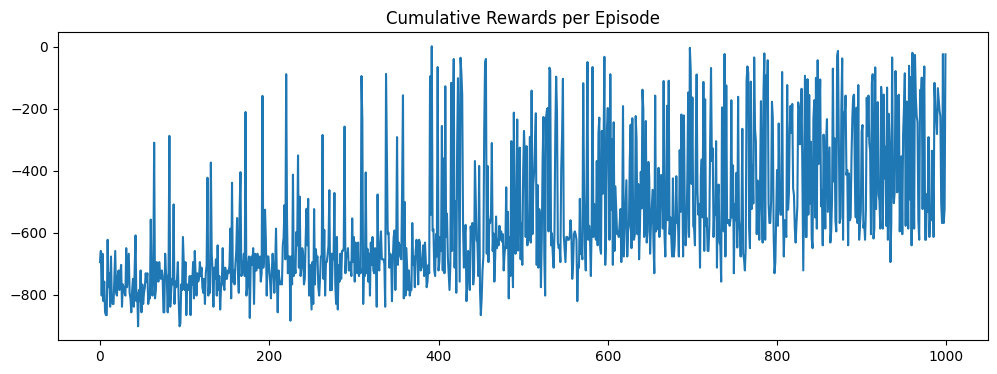

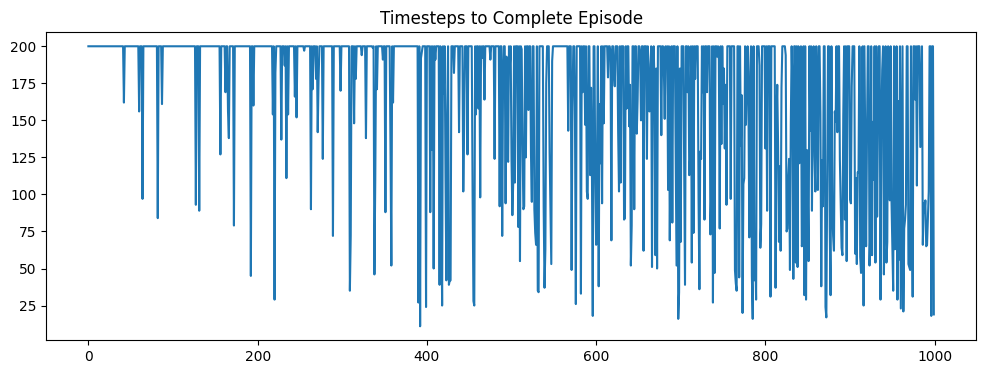

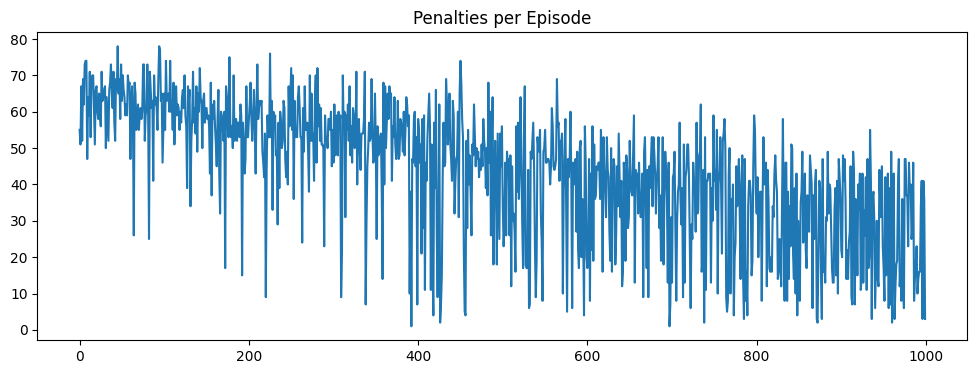

In [24]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Cumulative Rewards per Episode")
pd.Series(episode_rewards).plot(kind='line', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Timesteps to Complete Episode")
pd.Series(episode_steps).plot(kind='line', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Penalties per Episode")
pd.Series(episode_penalties).plot(kind='line', ax=ax)
plt.show()


### Evaluate the QAgent after training

In [25]:
def evaluate_agent(env, agent, n_eval_episodes):
    episode_rewards = []
    episode_penalties = []
    episode_steps = []

    for episode in tqdm(range(n_eval_episodes)):
        state, info = env.reset()
        done = False
        total_rewards_ep = 0
        total_penalties_ep = 0
        total_steps_ep = 0

        while not done:
            action = agent.get_action(state, 0)
            next_state, reward, terminated, truncated, info = env.step(action)
            total_rewards_ep += reward
            total_steps_ep += 1
            if reward == -10:
                total_penalties_ep += 1
            state = next_state
            done = terminated or truncated

        episode_rewards.append(total_rewards_ep)
        episode_steps.append(total_steps_ep)
        episode_penalties.append(total_penalties_ep)

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward, episode_rewards, episode_steps, episode_penalties


100%|██████████| 1000/1000 [00:03<00:00, 262.13it/s]


Mean reward = -215.69 +/- 224.51


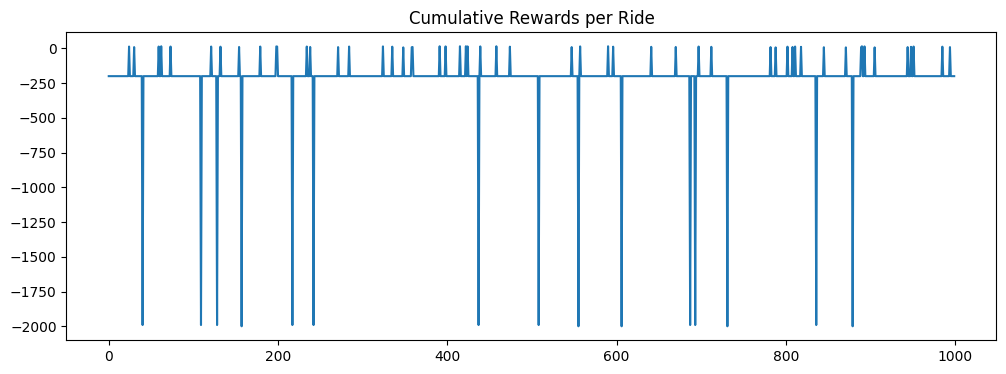

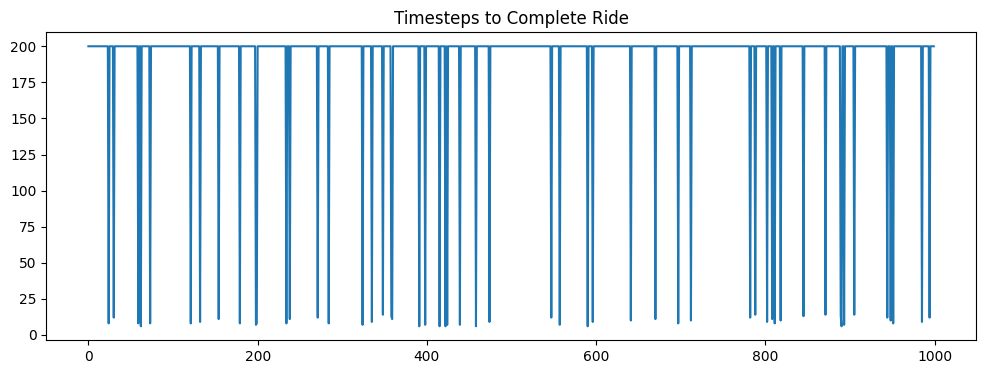

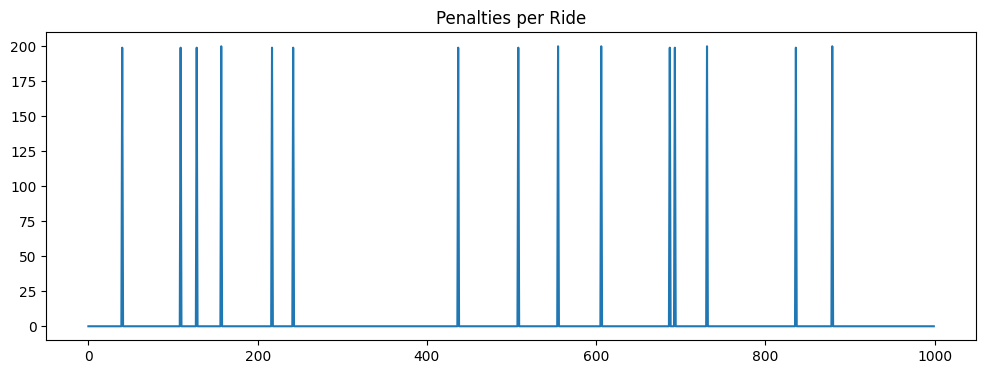

In [26]:
mean_reward, std_reward, episode_rewards, episode_steps, episode_penalties = evaluate_agent(env, agent, 1000)
print(f"Mean reward = {mean_reward:.2f} +/- {std_reward:.2f}")

fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Cumulative Rewards per Ride")
pd.Series(episode_rewards).plot(kind='line', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Timesteps to Complete Ride")
pd.Series(episode_steps).plot(kind='line', ax=ax)
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
ax.set_title("Penalties per Ride")
pd.Series(episode_penalties).plot(kind='line', ax=ax)
plt.show()


### Record a simulation as a video

In [27]:
def record_video(env, agent, out_directory, fps=1):
    images = []
    state, info = env.reset(seed=random.randint(0, 500))
    terminated = False
    truncated = False

    img = env.render()
    images.append(img)
    while not (terminated or truncated):
        action = np.argmax(agent.q_table[state])
        state, reward, terminated, truncated, info = env.step(action)
        img = env.render()
        images.append(img)
    imageio.mimsave(out_directory, [np.array(img) for img in images], fps=fps)


In [28]:
video_path = "./replay2.mp4"
record_video(env, agent, video_path, fps=1)

mp4 = open(video_path, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""<video width=400 controls><source src="{data_url}" type="video/mp4"></video>""")


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (550, 350) to (560, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
